In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import pickle
from torch.utils.data import Dataset, TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler
from scipy import stats
from tqdm import tqdm
# from skbio.stats.composition import clr
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
print(device)

from utils import *

import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 14

# later could use comet_ml for hyperparam optm
# import comet_ml
# API_KEY=
# experiment = Experiment(
#     api_key=API_KEY,
#     project_name="",
#     workspace="",
# )

cuda:0


### Filter datasets

In [51]:
## preprocess this subset of data
def save_preprocessed(p_data, name_data):
    data_df = pickle.load(open(p_data, "rb"))
    idx, data_df = data_df.iloc[:, :1], data_df.iloc[:, 1:]

    # remove emtpy samples first
    idx = idx.loc[data_df.sum(axis=1) > 0]
    data_df = data_df.loc[data_df.sum(axis=1) > 0]

    # add a filter of the NA OTUs/samples
    def get_unidentified(name, position=-2):
        # D-K-Ph-C-O-F-G
        checkpoint = name.split(".")[position]
        return (checkpoint=="NA" or checkpoint=="Incertae Sedis")
    na_spc = [spc for spc in list(data_df.columns)[1:] if get_unidentified(spc, -2)]
    print(f"Among {len(list(data_df.columns)[1:])} OTUs, {len(na_spc)} of them are unidentified at the order level")
    # plt.hist(np.log10(1e-4+np.array(data_df[na_spc].sum(axis=1))/np.array(data_df.sum(axis=1))), bins=20)
    # plt.xlabel("log10(Abundance of unidentified OTUs)")
    # plt.ylabel("Count of samples")
    # plt.axvline(np.log10(0.2), color="k")
    # plt.show()
    idx = idx[ np.array(data_df[na_spc].sum(axis=1))/np.array(data_df.sum(axis=1))<0.2 ]
    data_df = data_df [ np.array(data_df[na_spc].sum(axis=1))/np.array(data_df.sum(axis=1))<0.2 ]
    data_df = data_df.drop(na_spc, axis=1)
    
    '''
    remove the samples w/ low total abundance. 
    I checked that total abundance ~lognormal; remove the <-2sigma (~5%) lowest samples. 
    '''
    lower_bound = np.exp(np.mean(np.log(data_df.sum(axis=1)))-2*np.std(np.log(data_df.sum(axis=1))))
    idx = idx.loc[data_df.sum(axis=1) >= lower_bound]
    data_df = data_df.loc[data_df.sum(axis=1) >= lower_bound]

    ## remove the rare species (present in <5% samples)
    n_samples = data_df.shape[0]
    data_df = data_df.loc[:, (data_df>0).sum(axis=0) >= 0.05*n_samples]
    
    # remove emtpy samples again
    idx = idx.loc[data_df.sum(axis=1) > 0]
    data_df = data_df.loc[data_df.sum(axis=1) > 0]

    ## normalize to relative abundance
    data_df = data_df.div(data_df.sum(axis=1), axis=0)
    # data_df = pd.concat([idx, data_df], axis=1)

    features = (data_df>0).values.astype(float)
    labels = data_df.values
    print(f"{features.shape[0]} samples, {features.shape[1]} families") 

    ## save preprocessed data
    torch.save({"features":features, "labels":labels, "names":list(data_df.columns)}, f"../data/{name_data}_filtered.pt")
    
# save_preprocessed("../data/orig_species_1k.pkl", "1ksamples")
# save_preprocessed( "../data/orig_species_10k.pkl", "10ksamples")
save_preprocessed("../data/orig_species.pkl", "160ksamples")

Among 3158 OTUs, 420 of them are unidentified at the order level
124752 samples, 207 families


### Load, split and normalize the data

In [2]:
def load_filtered_data(p_data):
    features = torch.load(p_data)["features"]
    labels = torch.load(p_data)["labels"]
    spc_names = torch.load(p_data)["names"]
    
    original_indices = np.arange(len(features))
    train_indices, test_indices = train_test_split(
        original_indices,
        test_size=0.2,
        random_state=42,
    )
    X_train = features[train_indices]
    X_test = features[test_indices]
    y_train = labels[train_indices]
    y_test = labels[test_indices]
#     X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    ## clr transformation for outputs
    zero_thr = 1e-8
    gmean_train = (np.exp(np.nansum(np.log(y_train[y_train > 0]+zero_thr)) / np.size(y_train)))
    y_train_clr = np.log((y_train+zero_thr)/gmean_train)
    y_test_clr = np.log((y_test+zero_thr)/gmean_train)

    ## rescale the data
    scaler = preprocessing.MaxAbsScaler().fit(y_train_clr)
    # scaler = preprocessing.RobustScaler().fit(y_train_clr)
    y_train_scaled = scaler.transform(y_train_clr)
    y_test_scaled = scaler.transform(y_test_clr)

    ## transform to tensors
    X_train_scaled=torch.from_numpy(X_train).float()
    y_train_scaled=torch.from_numpy(y_train_scaled).float()
    X_test_scaled=torch.from_numpy(X_test).float()
    y_test_scaled=torch.from_numpy(y_test_scaled).float()

#     plt.hist(y_test_scaled.numpy().flatten(), bins=40)
#     plt.yscale("log")
#     plt.xlabel("Abundance score")
#     plt.ylabel("Counts")
#     plt.show()
    
    # keep the spc names and train/test split for evaluation use
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, {"spcs":spc_names,
                                                                          "train_idx": train_indices, 
                                                                          "test_idx": test_indices}

### Implement VAE

In [9]:
class VAETrainer:
    def __init__(self, model, train_loader, test_loader, optimizer, weights, device="cuda:0"):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.weights = weights
        self.device = device

    def train_one_epoch(self, zero_thr):
        self.model.train()
        total_loss, total_recon_loss, total_bce_loss, total_kl_loss = 0, 0, 0, 0
        total_acc = 0
        total_len = 0
        for batch in self.train_loader:
            if batch['Features'].size(0) == 1:
                continue 
            batch['Features'], batch['Labels'] = batch['Features'].to(device), batch['Labels'].to(device)
            
            self.optimizer.zero_grad()
#             recon_x, loss, recon_loss, kl_loss = compute_loss(self.model, batch['Features'], batch['Labels'], self.weights)
            b, nb, loss, recon_loss, bce_loss, kl_loss = compute_loss_2(self.model, batch['Features'], batch['Labels'], self.weights)
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_bce_loss += bce_loss.item()
            total_kl_loss += kl_loss.item()
            
#             out = ((recon_x.detach())>zero_thr).float()
            out = (b.detach()>0.5).float()
            total_acc += (out == batch['Features']).float().sum().item() # for binary-abundance
            total_len += batch["Features"].shape[0]

        return total_loss / total_len, \
               total_recon_loss / total_len, \
               total_bce_loss / total_len, \
               total_kl_loss / total_len, \
               total_acc / total_len / batch["Features"].shape[1]

    @torch.no_grad()
    def test_one_epoch(self, zero_thr):
        self.model.eval()
        total_loss, total_recon_loss, total_bce_loss, total_kl_loss = 0, 0, 0, 0
        total_acc = 0
        total_len = 0
        for batch in self.test_loader:
            batch['Features'], batch['Labels'] = batch['Features'].to(device), batch['Labels'].to(device)
            
#             recon_x, loss, recon_loss, kl_loss = compute_loss(self.model, batch['Features'], batch['Labels'], self.weights)
            b, nb, loss, recon_loss, bce_loss, kl_loss = compute_loss_2(self.model, batch['Features'], batch['Labels'], self.weights)
            
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_bce_loss += bce_loss.item()
            total_kl_loss += kl_loss.item()
            
#             out = ((recon_x.detach())>zero_thr).float()
            out = (b.detach()>0.5).float()
            total_acc += (out == batch['Features']).float().sum().item() # for binary-abundance
            total_len += batch["Features"].shape[0]

        return total_loss / total_len, \
               total_recon_loss / total_len, \
               total_bce_loss / total_len, \
               total_kl_loss / total_len, \
               total_acc / total_len / batch["Features"].shape[1]

In [10]:
def train_VAE_on_data(p_data, p_output, weights=[1.0, 1.0, 0.0]):
    '''
    weights: recon abundance loss; presence bce loss; KL divergence. 
    '''
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, annotations = load_filtered_data(p_data)
    spc_names = annotations["spcs"]
    class CustomDataset(Dataset):
        def __init__(self, features, labels, device=None):
            self.labels = labels
            self.features = features
        def __len__(self):
            return len(self.labels)
        def __getitem__(self, idx):
            label = self.labels[idx]
            data = self.features[idx]
            return {"Features": data, "Labels": label}
    Train = CustomDataset(X_train_scaled, y_train_scaled)
    Test = CustomDataset(X_test_scaled, y_test_scaled)

    input_dim = len(spc_names)
    hidden_dim = 2048
    latent_dim = 100
    epochs = 100
    lr = 1e-3
    weight_decay = 1e-4
    zero_thr = -0.8
    
#     # early stopping
#     patience = 10 
#     min_delta = 1e-3
#     best_loss = float('inf')
#     epochs_no_improve = 0
#     best_model_state = None

    model = VAE_2(input_dim, latent_dim, hidden_dim).to(device)
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=lr,
        weight_decay=weight_decay
    )

    ## create batch spits of data
    kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
    train_DS = DataLoader(Train, batch_size=100, shuffle=True, drop_last=False, **kwargs)
    test_DS = DataLoader(Test, batch_size=100, shuffle=True, drop_last=False, **kwargs)

    trainer = VAETrainer(model, train_DS, test_DS, optimizer, weights, device)

    train_losses = []
    test_losses = []
    train_acc = []
    test_acc = []
    MSEs, BCEs, KLDs = [], [], []
    for epoch in tqdm(range(epochs)):
        train_loss, MSE, BCE, KLD, acc = trainer.train_one_epoch(zero_thr)
        train_losses.append(train_loss)
        train_acc.append(acc)

        test_loss, MSE, BCE, KLD, acc = trainer.test_one_epoch(zero_thr)
        test_losses.append(test_loss)
        test_acc.append(acc)
        MSEs.append(MSE)
        BCEs.append(BCE)
        KLDs.append(KLD)
        
    torch.save({"model":model.state_dict(), "annotations":annotations}, p_output)        
        
    ## plot the training process
    train_acc=np.array(train_acc)
    test_acc = np.array(test_acc)
    plt.plot(range(train_acc.shape[0]), train_acc*100, c='blue', label = "train_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy, %")
    plt.ylim([0, 100])
    #     plt.xlim([0,1000])  # adjust the right leaving left unchanged
    plt.plot(range(test_acc.shape[0]), test_acc*100, c='red', label = "test_acc")
    prevalence=np.sum(X_train_scaled.numpy(), axis=0)/X_train_scaled.shape[0]
    prevalence[prevalence>=0.5]=1
    prevalence[prevalence<0.5]=0
    # horizontal line showing dumb predictions based on prevalence
    acc=(1-np.sum(np.abs(X_test_scaled.numpy()-prevalence))/X_test_scaled.shape[0]/prevalence.shape[0])*100
    plt.axhline(y = acc, color = 'orange', linestyle = '-.')
    plt.legend(frameon=False)
    handle = p_data.split("/")[-1][:-3]
    plt.savefig(f"../figures/trainingproc_acc_{handle}.pdf", bbox_inches="tight")
    plt.show()

    # show the losses
    lists = [MSEs, BCEs, KLDs]
    names = ["MSE", "Binary", "KLD"]
    for (yloss, loss_name) in zip(lists, names):
        plt.plot(range(train_acc.shape[0]), yloss, label=loss_name)
    plt.legend(frameon=False)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.yscale("log")
    handle = p_data.split("/")[-1][:-3]
    plt.savefig(f"../figures/trainingproc_loss_{handle}.pdf", bbox_inches="tight")
    plt.show()

torch.Size([620, 209]) torch.Size([620, 209])


100%|██████████| 100/100 [00:42<00:00,  2.35it/s]
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


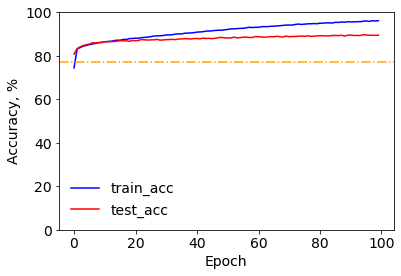

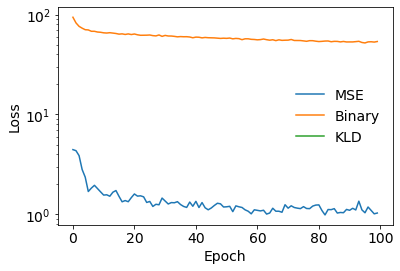

In [12]:
train_VAE_on_data("../data/1ksamples_filtered.pt", "../models/1ksamples_trained_AE.pt", weights=[1.0, 1.0, 0.0])

100%|██████████| 100/100 [01:40<00:00,  1.00s/it]


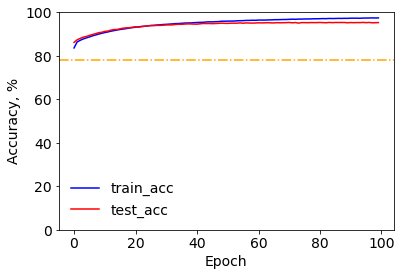

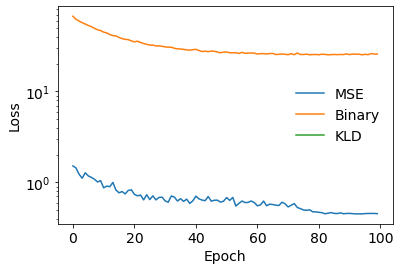

In [17]:
train_VAE_on_data("../data/10ksamples_filtered.pt", "../models/10ksamples_trained_AE.pt", weights=[1.0, 1.0, 0.0])

torch.Size([99801, 207]) torch.Size([99801, 207])


100%|██████████| 100/100 [21:43<00:00, 13.04s/it]


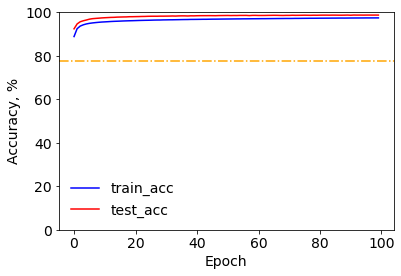

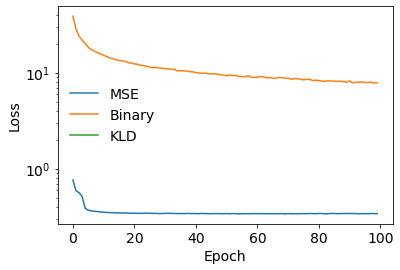

In [13]:
train_VAE_on_data("../data/160ksamples_filtered.pt", "../models/160ksamples_trained_AE.pt", weights=[1.0, 1.0, 0.0])